In [ ]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import os

# from random import shuffle
from sklearn.utils import shuffle

from functools import partial
from sklearn.metrics import classification_report as sklcls_report
from sklearn.metrics import f1_score, accuracy_score
from transformers import DataCollatorForLanguageModeling, AutoTokenizer, TFAutoModelForCausalLM
from os.path import join

2023-03-08 13:23:25.025109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 13:23:26.331803: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 13:23:26.331851: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 13:23:29.536733: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [1]:
from lib.BBData import character_dict, model_name, random_state
from lib.BBDataLoad import load_char_df, get_chatbot_predictions
from lib.BBVisualizations import BBVisualization, PlotsEnum
from random import sample

from lib.metrics.frequency import sentence_preprocess, FrequencyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2023-03-08 13:46:20.797903: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-08 13:46:22.168616: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-08 13:46:22.168709: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-08 13:46:25.999546: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

ModuleNotFoundError: No module named 'nlgmetricverse'

# __Introduction__

## __1 Data loading__

In [3]:
characters = list(character_dict.keys())
classification_report = partial(sklcls_report, labels=[i for i in range(len(characters))], 
                                target_names=characters, output_dict=True)

In [4]:
base_folder = os.getcwd()
data_folder = os.path.join(base_folder, 'Data', 'Characters')
figsize = (8, 8)

In [5]:
# prepare the dataset of all documents
character_docs = dict()
# foreach character in ours dataset
for character in characters:
    if character == 'Default':
        # read Default dataset and sample 0.02 fraction of the whole dataset
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.tsv'), 
                         names=[character, 'response'], sep='\t')
        df = df.sample(frac=0.02, random_state=random_state)
        df['response'] = df['response'].apply(lambda x: x[3:])
        df[character] = df[character].apply(lambda x: x[3:])
    else:
        # read other dataset 
        df = pd.read_csv(os.path.join(data_folder, character, f'{character}.csv'))
    # convert dataframes to list
    tmp_list = df['response'].tolist()
    # attach the list to the dictionary of documents of character
    character_docs[character] = tmp_list

In [6]:
# preprocess datasets
for character in characters:
    for i in tqdm(range(len(character_docs[character]))):
        sentence, relevant = sentence_preprocess(character_docs[character][i])
        if relevant:
            character_docs[character][i] = sentence

100%|██████████| 14747/14747 [00:07<00:00, 1879.01it/s]


In [7]:
# test size for splitting
test_size = 0.33
# prepare the dictionaries of train and set
character_docs_train = {}
character_docs_test = {}
n_docs = 0
# for each character in ours data
for c in characters:
    # shuffle data
    character_docs[c] = shuffle(character_docs[c], random_state=random_state)
    # split the dataset in train e test set
    end_idx = int(len(character_docs[c]) * test_size)
    character_docs_train[c] = character_docs[c][end_idx:]
    n_docs += len(character_docs[c][end_idx:])
    character_docs_test[c] = character_docs[c][:end_idx]

## __2 State of the art__

### __2.1 Chatbot 3plet Classifier__

### __2.2 Emotion Classifier__

Results on emotion analysis were, unfortunately, disappointing: although single sentences can be classified more or less correctly, their average quickly degrades to pretty much the same output. We have found no significant differences with respect to the dataset taken under consideration.

In [ ]:
BBVisualization.load_visualization(PlotsEnum.ECR.value, character='Barney').plot()

### __2.3 Frequency Chatbot Classifier__

In [8]:
# Initialize and train the FrequencyClassifier
ctfidf_classifier = FrequencyClassifier(characters, mode='c-tf-idf')
ctfidf_classifier.train(list(character_docs_train.values()))

c-TF-IDF classifier test accuracy: 1.00
c-TF-IDF classifier test f1 score: 1.00


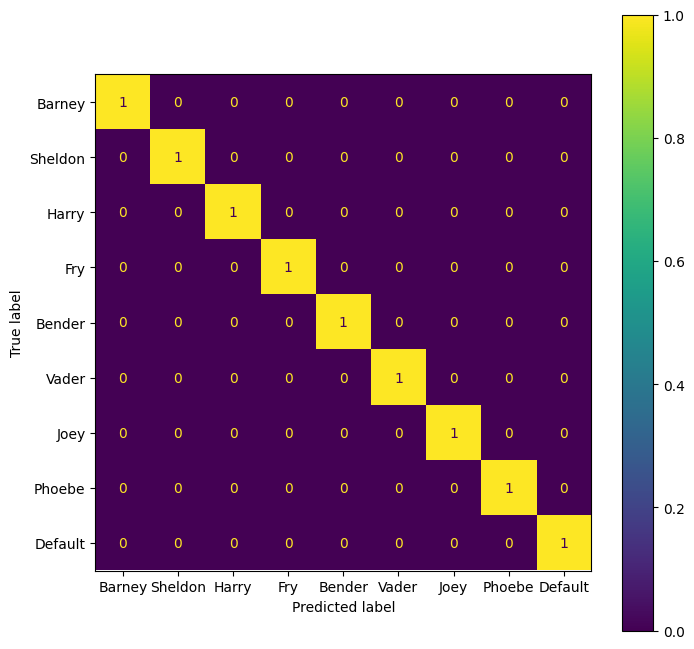

In [9]:
# real y value 
y_true = [characters.index(c) for c in characters]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # compute the prediction
    prediction = ctfidf_classifier.predict(character_docs_test[c])
    raw_predictions[c].append(prediction)
    # extract the argmax of the prediction which is the index of the character predicted
    y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

In [10]:
# divide a list in sublists of equal size of elements
def subgroup_list(l, n):
    return [l[e:e+n] for e in range(0, len(l), n)]

In order to understand the real behaviour of this model, we will divide the test set in lists of subgroups of 3 and 10 consecutive lines, to add a level of complexity.

Subgroups of 3 consecutive lines

c-TF-IDF classifier test accuracy: 0.70
c-TF-IDF classifier test f1 score: 0.65


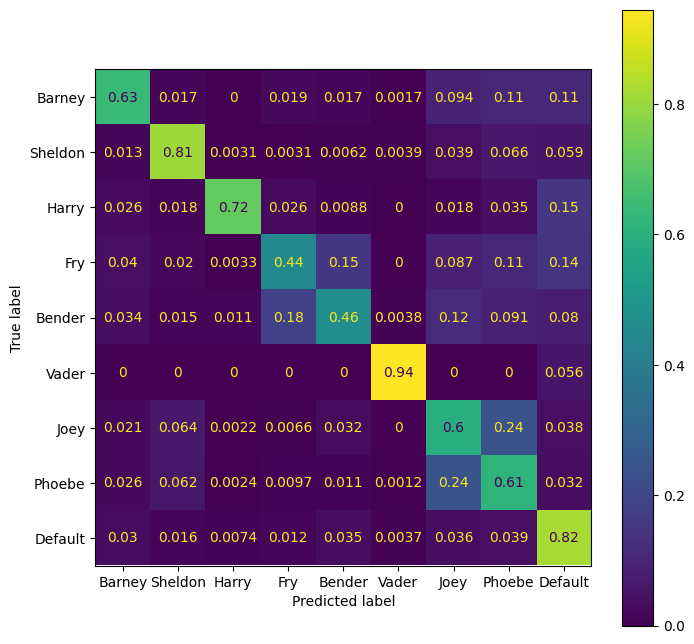

In [11]:
# 3 consecutive lines
m = 3
# real y value 
y_true = [characters.index(c) for c in characters for d in subgroup_list(character_docs_test[c], m)]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # document d to predict compose by 3 consecutive lines
    for d in subgroup_list(character_docs_test[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        raw_predictions[c].append(prediction)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

c-TF-IDF classifier test accuracy: 0.91
c-TF-IDF classifier test f1 score: 0.90


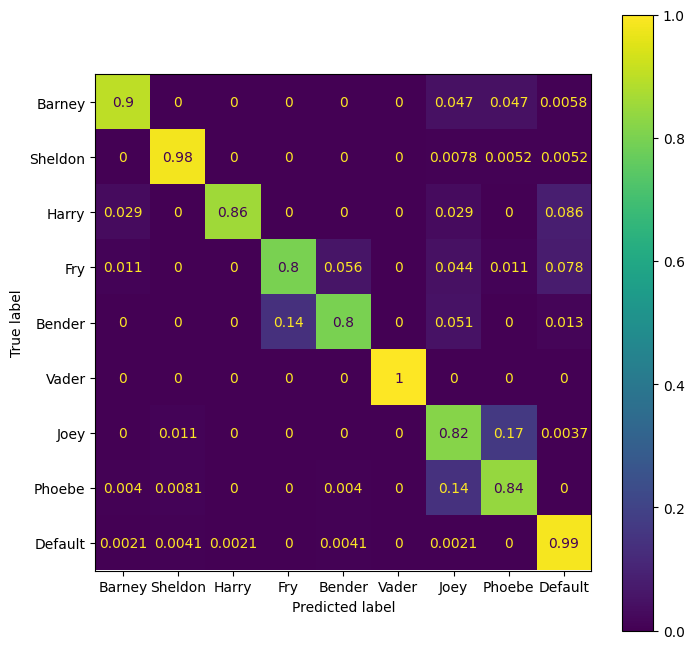

In [12]:
# 10 consecutive lines
m = 10
# real y value 
y_true = [characters.index(c) for c in characters for d in subgroup_list(character_docs_test[c], m)]
# compute y predicted by the model
y_pred = []
raw_predictions = {c:[] for c in characters}
for c in characters:
    # document d to predict compose by 3 consecutive lines
    for d in subgroup_list(character_docs_test[c], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        raw_predictions[c].append(prediction)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

Thus as we can, the amount of sentences in queries can largely affect the evaluation, increasing the confidence in deciding which should be the character in prediction

It can be noticed also that the problem seems to be much difficult for distinguishing characters coming from a common tv show (e.g. _Fry_-_Bender_ from _Futurama_ and _Joey_-_Phoebe_ from _Friends_). A possible explaination to this results could come from the authors's script style of a given tv show, or by common topics present in the characters lines. 

Test the model on the chatbots responses and check the predictions of the Frequency classifier

In [13]:
# select the character to test
character = 'Barney'
# takes the list of characters without Default
characters_noDefault = characters.copy()
characters_noDefault.remove('Default')
# initialize the frequency classifier and train over the documents
tfidf_classifier = FrequencyClassifier(characters, mode='c-tf-idf')
tfidf_classifier.train(list(character_docs.values()))
# initialize the tokenizer and data_collator of models
tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=join("..", "cache"))
tokenizer.pad_token = '#'
data_collator = DataCollatorForLanguageModeling(mlm=False, tokenizer=tokenizer, return_tensors='tf')

In [14]:
# load dataset in hugging face dictionary model
character_hg = {c:None for c in characters_noDefault}
for c in characters_noDefault:
    # extract the character checkpoint
    character_checkpoint = join(data_folder, c, character_dict[c]['checkpoint_folder'])
    # load the dataset dict of each character
    character_hg[c] = load_char_df(c, base_folder)


Found cached dataset csv (/app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c7d3ec6662680d64.arrow and /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-1dc91bae0d09a1f5.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c3793660279940c7.arrow and /app/notebooks/cache/csv/default-dd07b0e7e3df8359/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-f96aafc4d74714b6.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-f33ed36c10b4cc15.arrow and /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0d25fe4cff24b6d8.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-24eef478de0c1383.arrow and /app/notebooks/cache/csv/default-f764b657cc592952/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e905c0428b937ac5.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-30e8f9fa27404050.arrow and /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-80fb22e93debfa0d.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-5abe9faada8ea36b.arrow and /app/notebooks/cache/csv/default-095a0ca481b515c5/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0c2954af190ebfa2.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-9b0899ca43c26ced.arrow and /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-e2ae211b7013b878.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-98c63d42105f35bf.arrow and /app/notebooks/cache/csv/default-b4222c58ca1f28b4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-11d0ce00f9c40318.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-6acf41cc747c5497.arrow and /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-a31613a92ea4d34b.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-4b8e13a055f9e92d.arrow and /app/notebooks/cache/csv/default-5e5168f7d8ab1f87/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-278e55854694342e.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-631578260ee6077f.arrow and /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-eaed2fbf965b5546.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-5926ef784682cfbd.arrow and /app/notebooks/cache/csv/default-63cf32be541b1cf6/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-8c652d76529dfe6a.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-0ccef7e72c7d6cd6.arrow and /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-94c6c691118c1b00.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-4f01e0ab00bb9adb.arrow and /app/notebooks/cache/csv/default-d720ea12879cd835/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-c38ed1090ba9a197.arrow
Found cached dataset csv (/app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-eebdd3698dff8a7f.arrow and /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-667871d791919918.arrow
Loading cached split indices for dataset at /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-ae70a2b421f0121b.arrow and /app/notebooks/cache/csv/default-b6aaaae5f5af64a1/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317/cache-874c8b49bfbdc50f.arrow


c-TF-IDF classifier test accuracy: 0.93
c-TF-IDF classifier test f1 score: 0.84


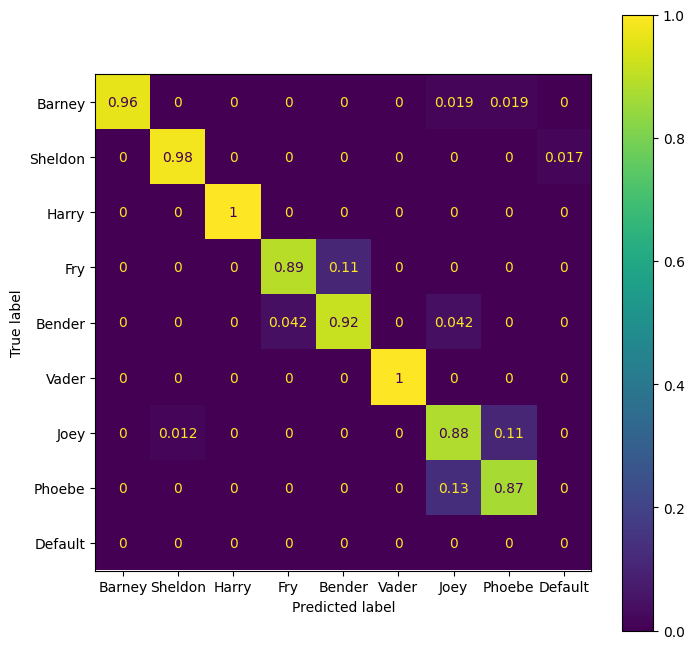

In [15]:
# size of each subgroup
m = 10

y_true = []
y_pred = []

for c in characters_noDefault:
    # Takes a subset of the testset as sample question
    for d in subgroup_list(character_hg[c]['test']['response'], m):
        # compute the prediction
        prediction = ctfidf_classifier.predict(d)
        # extract the argmax of the prediction which is the index of the character predicted
        y_pred.append(np.argmax(list(prediction.values())))
        y_true.append(characters_noDefault.index(c))

# print the classification report and scores
print('c-TF-IDF classifier test accuracy: {:.2f}\nc-TF-IDF classifier test f1 score: {:.2f}'.format(
        accuracy_score(y_pred, y_true), f1_score(y_pred, y_true, average='macro'))
     )
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=characters)
fig, ax = plt.subplots(figsize=figsize)
disp.plot(ax=ax)

By the way results are very surprising also with the chatbot responses, but the problem of characters coming from common tv show is still there, confirming the complexity of this task.

### __2.4 DistillBERT Classifier__